In [1]:
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import numpy as np
import random
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import MinMaxScaler
from pytorch_tabnet.augmentations import RegressionSMOTE
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Fix random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
sampler = TPESampler(seed=seed)

# Pre-processing input data

In [3]:
def bits_to_MiB(row):
	# verify if has string ' MiB'
	if 'MiB' in str(row):
		row = row.replace(' MiB', '')
		row = float(row)
	else:
		row = float(row) / np.power(2, 20)
	return row


def MHz_to_GHz(row):
	# verify if has string ' GHz'
	if 'GHz' in str(row):
		row = row.replace(' GHz', '')
		# convert to float
		row = float(row)
	else:
		row = row.replace(' MHz', '')
		row = float(row) / 1000
	return row

In [4]:
results_df = pd.read_csv('../results_new/execution_time.csv')
results_savio_df = pd.read_csv('../results_savio_new/execution_time.csv')
results_df = pd.concat([results_df, results_savio_df], ignore_index=True)
# preprocessing
results_df['total_cpu_usage'] = results_df['total_cpu_usage'].str.replace('%', '').astype(float) / 100
results_df['max_ram_usage'] = results_df['max_ram_usage'] / 1024
results_df['l2_cache_size'] = results_df['l2_cache_size'].apply(bits_to_MiB)
results_df['l3_cache_size'] = results_df['l3_cache_size'].apply(bits_to_MiB)
results_df['ghz_actual_friendly'] = results_df['hz_actual_friendly'].apply(MHz_to_GHz)
results_df['ghz_advertised_friendly'] = results_df['hz_advertised_friendly'].str.replace('GHz', '').astype(float)
results_df = results_df.drop(columns=['hz_actual_friendly', 'hz_advertised_friendly', 'arch', 'vendor_id_raw'])

In [5]:
# Make the target dataset
target_df = results_df[['total_time', 'brand_raw', 'count', 'l2_cache_size', 'l3_cache_size', 'l2_cache_line_size', 'l2_cache_associativity', 'ghz_advertised_friendly', 'benchmark']].copy()
# Rename columns to *_target
target_df = target_df.rename(columns={
    'total_time': 'total_time_target',
    'brand_raw': 'brand_raw_target',
    'count': 'count_target',
    'l2_cache_size': 'l2_cache_size_target',
    'l3_cache_size': 'l3_cache_size_target',
    'l2_cache_line_size': 'l2_cache_line_size_target',
    'l2_cache_associativity': 'l2_cache_associativity_target',
    'ghz_advertised_friendly': 'ghz_advertised_friendly_target',
})

dataset_df = pd.merge(results_df, target_df, how='inner', on='benchmark')
dataset_df = dataset_df[dataset_df['brand_raw'] != dataset_df['brand_raw_target']]
dataset_df.head(2)

,total_time,total_cpu_usage,max_ram_usage,brand_raw,count,l2_cache_size,l3_cache_size,l2_cache_line_size,l2_cache_associativity,benchmark,ghz_actual_friendly,ghz_advertised_friendly,total_time_target,brand_raw_target,count_target,l2_cache_size_target,l3_cache_size_target,l2_cache_line_size_target,l2_cache_associativity_target,ghz_advertised_friendly_target
5,13.47,0.99,1436.714844,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,12,1.5,12.0,256,6,KNP,4.1729,2.9,45.91,13th Gen Intel(R) Core(TM) i5-1335U,12,7.5,12.0,1280,7,2.496
6,13.47,0.99,1436.714844,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,12,1.5,12.0,256,6,KNP,4.1729,2.9,25.77,13th Gen Intel(R) Core(TM) i5-1335U,12,7.5,12.0,1280,7,2.496


In [6]:
# remove one computer for testing
g_train = dataset_df[(dataset_df['brand_raw'] != '13th Gen Intel(R) Core(TM) i5-1335U') & (dataset_df['brand_raw_target'] != '13th Gen Intel(R) Core(TM) i5-1335U')]
g_test = dataset_df[dataset_df['brand_raw_target'] == '13th Gen Intel(R) Core(TM) i5-1335U']

In [7]:
mm_df = dataset_df[dataset_df['benchmark'].isin(['MATRIX_MULT', 'MATRIX_MULT2', 'MATRIX_MULT3'])]
# remove one computer for testing
mm_train = mm_df[(mm_df['brand_raw'] != '13th Gen Intel(R) Core(TM) i5-1335U') & (mm_df['brand_raw_target'] != '13th Gen Intel(R) Core(TM) i5-1335U')]
mm_test = mm_df[mm_df['brand_raw_target'] == '13th Gen Intel(R) Core(TM) i5-1335U']

In [8]:
st_df = dataset_df[~dataset_df['benchmark'].isin(['MATRIX_MULT', 'MATRIX_MULT2', 'MATRIX_MULT3'])]
# remove one computer for testing
st_train = st_df[(st_df['brand_raw'] != '13th Gen Intel(R) Core(TM) i5-1335U') & (st_df['brand_raw_target'] != '13th Gen Intel(R) Core(TM) i5-1335U')]
st_test = st_df[st_df['brand_raw_target'] == '13th Gen Intel(R) Core(TM) i5-1335U']

In [9]:
# load test dataset
# g_test = pd.read_csv('csv/g_test.csv')
# st_test = pd.read_csv('csv/st_test.csv')
# mm_test = pd.read_csv('csv/mm_test.csv')

In [10]:
target = 'total_time_target'
features = mm_test.columns.copy().drop(target).drop(['benchmark','brand_raw', 'brand_raw_target'])
features_st = features.copy().drop(['count', 'count_target'])

In [11]:
# general data
## split data
X_g_train = g_train[features]
y_g_train = g_train[target]

## test
X_g_test = g_test[features]
y_g_test = g_test[target]

## normalize data
x_g_scaler = MinMaxScaler(feature_range=(0, 1))
X_g_train = x_g_scaler.fit_transform(X_g_train)
X_g_test = x_g_scaler.transform(X_g_test)
y_g_scaler = MinMaxScaler(feature_range=(0, 1))
y_g_train = y_g_scaler.fit_transform(y_g_train.values.reshape(-1, 1))
y_g_test = y_g_scaler.transform(y_g_test.values.reshape(-1, 1))

In [12]:
# single thread data
## split data
X_st_train = st_train[features_st]
y_st_train = st_train[target]

## test
X_st_test = st_test[features_st]
y_st_test = st_test[target]

## normalize data
x_st_scaler = MinMaxScaler(feature_range=(0, 1))
X_st_train = x_st_scaler.fit_transform(X_st_train)
X_st_test = x_st_scaler.transform(X_st_test)
y_st_scaler = MinMaxScaler(feature_range=(0, 1))
y_st_train = y_st_scaler.fit_transform(y_st_train.values.reshape(-1, 1))
y_st_test = y_st_scaler.transform(y_st_test.values.reshape(-1, 1))

In [13]:
# multi thread data
## split data
X_mm_train = mm_train[features]
y_mm_train = mm_train[target]

X_mm_test = mm_test[features]
y_mm_test = mm_test[target]

## normalize data
x_mm_scaler = MinMaxScaler(feature_range=(0, 1))
X_mm_train = x_mm_scaler.fit_transform(X_mm_train)
X_mm_test = x_mm_scaler.transform(X_mm_test)
y_mm_scaler = MinMaxScaler(feature_range=(0, 1))
y_mm_train = y_mm_scaler.fit_transform(y_mm_train.values.reshape(-1, 1))
y_mm_test = y_mm_scaler.transform(y_mm_test.values.reshape(-1, 1))

In [14]:
aug = RegressionSMOTE(p=0.2)

# Training

In [15]:
models_folder = '../models/tabnet'
patience = 25
num_epochs = 100

In [16]:
def inv_scaling(y, y_scaler):
    return y_scaler.inverse_transform(y.reshape(-1, 1))

## General

In [17]:
# general model initialization
model_g = TabNetRegressor()
model_g.fit(
	X_train=X_g_train, y_train=y_g_train,
	eval_set=[(X_g_train, y_g_train), (X_g_test, y_g_test)],
	eval_name=['train', 'valid'],
	eval_metric=['mae', 'rmse', 'mse'],
	max_epochs=num_epochs,
	patience=patience,
	batch_size=1024, virtual_batch_size=128,
	num_workers=0,
	drop_last=False,
	augmentations=aug
)

preds = model_g.predict(X_g_test)
preds = inv_scaling(preds, y_g_scaler)
y_scaled = inv_scaling(y_g_test, y_g_scaler)
mse = mean_squared_error(y_scaled, preds)
mae = mean_absolute_error(y_scaled, preds)
print(f"MSE: {mse} - RMSE: {np.sqrt(mse)} - MAE: {mae}")

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.10108 | train_mae: 0.07526 | train_rmse: 0.12143 | train_mse: 0.01475 | valid_mae: 0.15099 | valid_rmse: 0.24589 | valid_mse: 0.06046 |  0:00:01s
epoch 1  | loss: 0.01107 | train_mae: 0.06614 | train_rmse: 0.11522 | train_mse: 0.01328 | valid_mae: 0.14517 | valid_rmse: 0.24244 | valid_mse: 0.05878 |  0:00:02s
epoch 2  | loss: 0.00737 | train_mae: 0.06708 | train_rmse: 0.11628 | train_mse: 0.01352 | valid_mae: 0.15376 | valid_rmse: 0.24486 | valid_mse: 0.05996 |  0:00:02s
epoch 3  | loss: 0.00595 | train_mae: 0.06844 | train_rmse: 0.11591 | train_mse: 0.01343 | valid_mae: 0.15444 | valid_rmse: 0.23868 | valid_mse: 0.05697 |  0:00:03s
epoch 4  | loss: 0.00515 | train_mae: 0.06576 | train_rmse: 0.11084 | train_mse: 0.01229 | valid_mae: 0.14825 | valid_rmse: 0.22852 | valid_mse: 0.05222 |  0:00:04s
epoch 5  | loss: 0.00463 | train_mae: 0.06515 | train_rmse: 0.10944 | train_mse: 0.01198 | valid_mae: 0.1473  | valid_rmse: 0.22593 | valid_mse: 0.05105 |  0:00:05s
epoch 6  |

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 221.7539308524807 - RMSE: 14.89140459635963 - MAE: 10.19929129322155


In [18]:
# save model
model_g.save_model(f'{models_folder}/general')

Successfully saved model at ../models/tabnet/general.zip


'../models/tabnet/general.zip'

## Single Thread

In [19]:
# single thread model initialization
model_st = TabNetRegressor()
model_st.fit(
	X_train=X_st_train, y_train=y_st_train,
	eval_set=[(X_st_train, y_st_train), (X_st_test, y_st_test)],
	eval_name=['train', 'valid'],
	eval_metric=['mae', 'rmse', 'mse'],
	max_epochs=num_epochs,
	patience=patience,
	batch_size=1024, virtual_batch_size=128,
	num_workers=0,
	drop_last=False,
	augmentations=aug
)

preds = model_st.predict(X_st_test)
preds = inv_scaling(preds, y_st_scaler)
y_scaled = inv_scaling(y_st_test, y_st_scaler)
mse = mean_squared_error(y_scaled, preds)
mae = mean_absolute_error(y_scaled, preds)
print(f"MSE: {mse} - RMSE: {np.sqrt(mse)} - MAE: {mae}")

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.19807 | train_mae: 0.07771 | train_rmse: 0.13791 | train_mse: 0.01902 | valid_mae: 0.15479 | valid_rmse: 0.27366 | valid_mse: 0.07489 |  0:00:00s
epoch 1  | loss: 0.0188  | train_mae: 0.072   | train_rmse: 0.13178 | train_mse: 0.01736 | valid_mae: 0.15269 | valid_rmse: 0.27023 | valid_mse: 0.07302 |  0:00:01s
epoch 2  | loss: 0.01195 | train_mae: 0.06228 | train_rmse: 0.11208 | train_mse: 0.01256 | valid_mae: 0.12529 | valid_rmse: 0.23528 | valid_mse: 0.05536 |  0:00:02s
epoch 3  | loss: 0.00741 | train_mae: 0.05819 | train_rmse: 0.10537 | train_mse: 0.0111  | valid_mae: 0.12371 | valid_rmse: 0.23155 | valid_mse: 0.05362 |  0:00:02s
epoch 4  | loss: 0.00542 | train_mae: 0.05728 | train_rmse: 0.10152 | train_mse: 0.01031 | valid_mae: 0.12357 | valid_rmse: 0.23481 | valid_mse: 0.05513 |  0:00:03s
epoch 5  | loss: 0.00473 | train_mae: 0.05963 | train_rmse: 0.09631 | train_mse: 0.00928 | valid_mae: 0.11363 | valid_rmse: 0.22618 | valid_mse: 0.05116 |  0:00:04s
epoch 6  |

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


MSE: 162.34035330470687 - RMSE: 12.74128538667535 - MAE: 9.330004085350037


In [20]:
# save model
model_st.save_model(f'{models_folder}/single_thread')

Successfully saved model at ../models/tabnet/single_thread.zip


'../models/tabnet/single_thread.zip'

## Multi Thread

In [21]:
# multi thread model initialization
model_mm = TabNetRegressor()
model_mm.fit(
	X_train=X_mm_train, y_train=y_mm_train,
	eval_set=[(X_mm_train, y_mm_train), (X_mm_test, y_mm_test)],
	eval_name=['train', 'valid'],
	eval_metric=['mae', 'rmse', 'mse'],
	max_epochs=num_epochs,
	patience=patience,
	batch_size=1024, virtual_batch_size=128,
	num_workers=0,
	drop_last=False,
	augmentations=aug
)

preds = model_mm.predict(X_mm_test)
preds = inv_scaling(preds, y_mm_scaler)
y_scaled = inv_scaling(y_mm_test, y_mm_scaler)
mse = mean_squared_error(y_scaled, preds)
mae = mean_absolute_error(y_scaled, preds)
print(f"MSE: {mse} - RMSE: {np.sqrt(mse)} - MAE: {mae}")

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.53002 | train_mae: 0.15557 | train_rmse: 0.21755 | train_mse: 0.04733 | valid_mae: 0.395   | valid_rmse: 0.39944 | valid_mse: 0.15955 |  0:00:00s
epoch 1  | loss: 0.06123 | train_mae: 0.13185 | train_rmse: 0.17215 | train_mse: 0.02964 | valid_mae: 0.3488  | valid_rmse: 0.35109 | valid_mse: 0.12327 |  0:00:00s
epoch 2  | loss: 0.03735 | train_mae: 0.13953 | train_rmse: 0.17346 | train_mse: 0.03009 | valid_mae: 0.39686 | valid_rmse: 0.39834 | valid_mse: 0.15868 |  0:00:00s
epoch 3  | loss: 0.02401 | train_mae: 0.13004 | train_rmse: 0.16372 | train_mse: 0.0268  | valid_mae: 0.40331 | valid_rmse: 0.4048  | valid_mse: 0.16387 |  0:00:00s
epoch 4  | loss: 0.0186  | train_mae: 0.13138 | train_rmse: 0.16072 | train_mse: 0.02583 | valid_mae: 0.36677 | valid_rmse: 0.36941 | valid_mse: 0.13646 |  0:00:01s
epoch 5  | loss: 0.0141  | train_mae: 0.13424 | train_rmse: 0.16313 | train_mse: 0.02661 | valid_mae: 0.34923 | valid_rmse: 0.35399 | valid_mse: 0.12531 |  0:00:01s
epoch 6  |

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [22]:
# save model
model_mm.save_model(f'{models_folder}/multi_thread')

Successfully saved model at ../models/tabnet/multi_thread.zip


'../models/tabnet/multi_thread.zip'

# Load models

In [23]:
model_g = TabNetRegressor()
model_st = TabNetRegressor()
model_mm = TabNetRegressor()
model_g.load_model(f'{models_folder}/general.zip')
model_st.load_model(f'{models_folder}/single_thread.zip')
model_mm.load_model(f'{models_folder}/multi_thread.zip')

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [24]:
def describe_val(model, X, y, y_scaler):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}

	predictions = model.predict(X)
	predictions = inv_scaling(predictions, y_scaler)
	y_scaled = inv_scaling(y, y_scaler)
	index_min = np.argmin(np.abs(predictions - y_scaled))
	min_instance["prediction"] = predictions[index_min].item()
	min_instance["actual"] = y_scaled[index_min].item()
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y_scaled))
	max_instance["prediction"] = predictions[index_max].item()
	max_instance["actual"] = y_scaled[index_max].item()
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions

In [25]:
# general model
print("Validation set general model")
min_instance, max_instance, predictions = describe_val(model_g, X_g_test, y_g_test, y_g_scaler)
y_scaled = inv_scaling(y_g_test, y_g_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("---")
print("Min instance")
print(g_test.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(g_test.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set general model


Mean prediction: 25.18744659423828 | Std actual: 23.330150604248047
Mean actual: 35.041486486486484 | Std actual: 28.83706408578472
Mean Error: 10.19929129322155 | Std Error: 10.850271331561057
---
Min instance
total_time                                                           60.38
total_cpu_usage                                                       0.99
max_ram_usage                                                    78.292969
brand_raw                         Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz
count                                                                   56
l2_cache_size                                                         70.0
l3_cache_size                                                         42.0
l2_cache_line_size                                                     256
l2_cache_associativity                                                   6
benchmark                                                             TSP4
ghz_actual_friendly                    

In [26]:
# single thread model
print("Validation set single thread model")
min_instance, max_instance, predictions = describe_val(model_st, X_st_test, y_st_test, y_st_scaler)
y_scaled = inv_scaling(y_st_test, y_st_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(st_test.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(st_test.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model
Mean prediction: 25.63242530822754 | Std actual: 25.016273498535156
Mean actual: 34.75261290322581 | Std actual: 31.49396398818138
Mean Error: 9.330004085350037 | Std Error: 8.67706039347765
Min instance
total_time                                                       12.37
total_cpu_usage                                                   0.99
max_ram_usage                                              1435.183594
brand_raw                         12th Gen Intel(R) Core(TM) i5-12400F
count                                                               12
l2_cache_size                                                      7.5
l3_cache_size                                                     18.0
l2_cache_line_size                                                1280
l2_cache_associativity                                               7
benchmark                                                          KNP
ghz_actual_friendly                                

In [27]:
# multi thread model
print("Validation set multi thread model")
min_instance, max_instance, predictions = describe_val(model_mm, X_mm_test, y_mm_test, y_mm_scaler)
y_scaled = inv_scaling(y_mm_test, y_mm_scaler)
errors = np.abs(predictions - y_scaled)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(y_scaled)} | Std actual: {np.std(y_scaled)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(mm_test.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(mm_test.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set multi thread model
Mean prediction: 15.292021751403809 | Std actual: 2.2839832305908203
Mean actual: 36.534 | Std actual: 0.8569854141115829
Mean Error: 21.24197877311706 | Std Error: 2.4394677840444983
Min instance
total_time                                                            23.88
total_cpu_usage                                                        1.92
max_ram_usage                                                   2332.714844
brand_raw                         Intel(R) Xeon(R) CPU E5-2623 v3 @ 3.00GHz
count                                                                     8
l2_cache_size                                                           2.0
l3_cache_size                                                          10.0
l2_cache_line_size                                                      256
l2_cache_associativity                                                    6
benchmark                                                       MATRIX_MULT
ghz_actua

# Explanation

In [28]:
print(model_g.feature_importances_)
print(model_st.feature_importances_)
print(model_mm.feature_importances_)

AttributeError: 'TabNetRegressor' object has no attribute 'feature_importances_'

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

def explain_matrix_plot(model, X_test):
	explain_matrix, masks = model.explain(X_test)
	fig, axs = plt.subplots(1, 3, figsize=(20,20))
	for i in range(3):
		axs[i].imshow(masks[i][:50])
		axs[i].set_title(f"mask {i}")

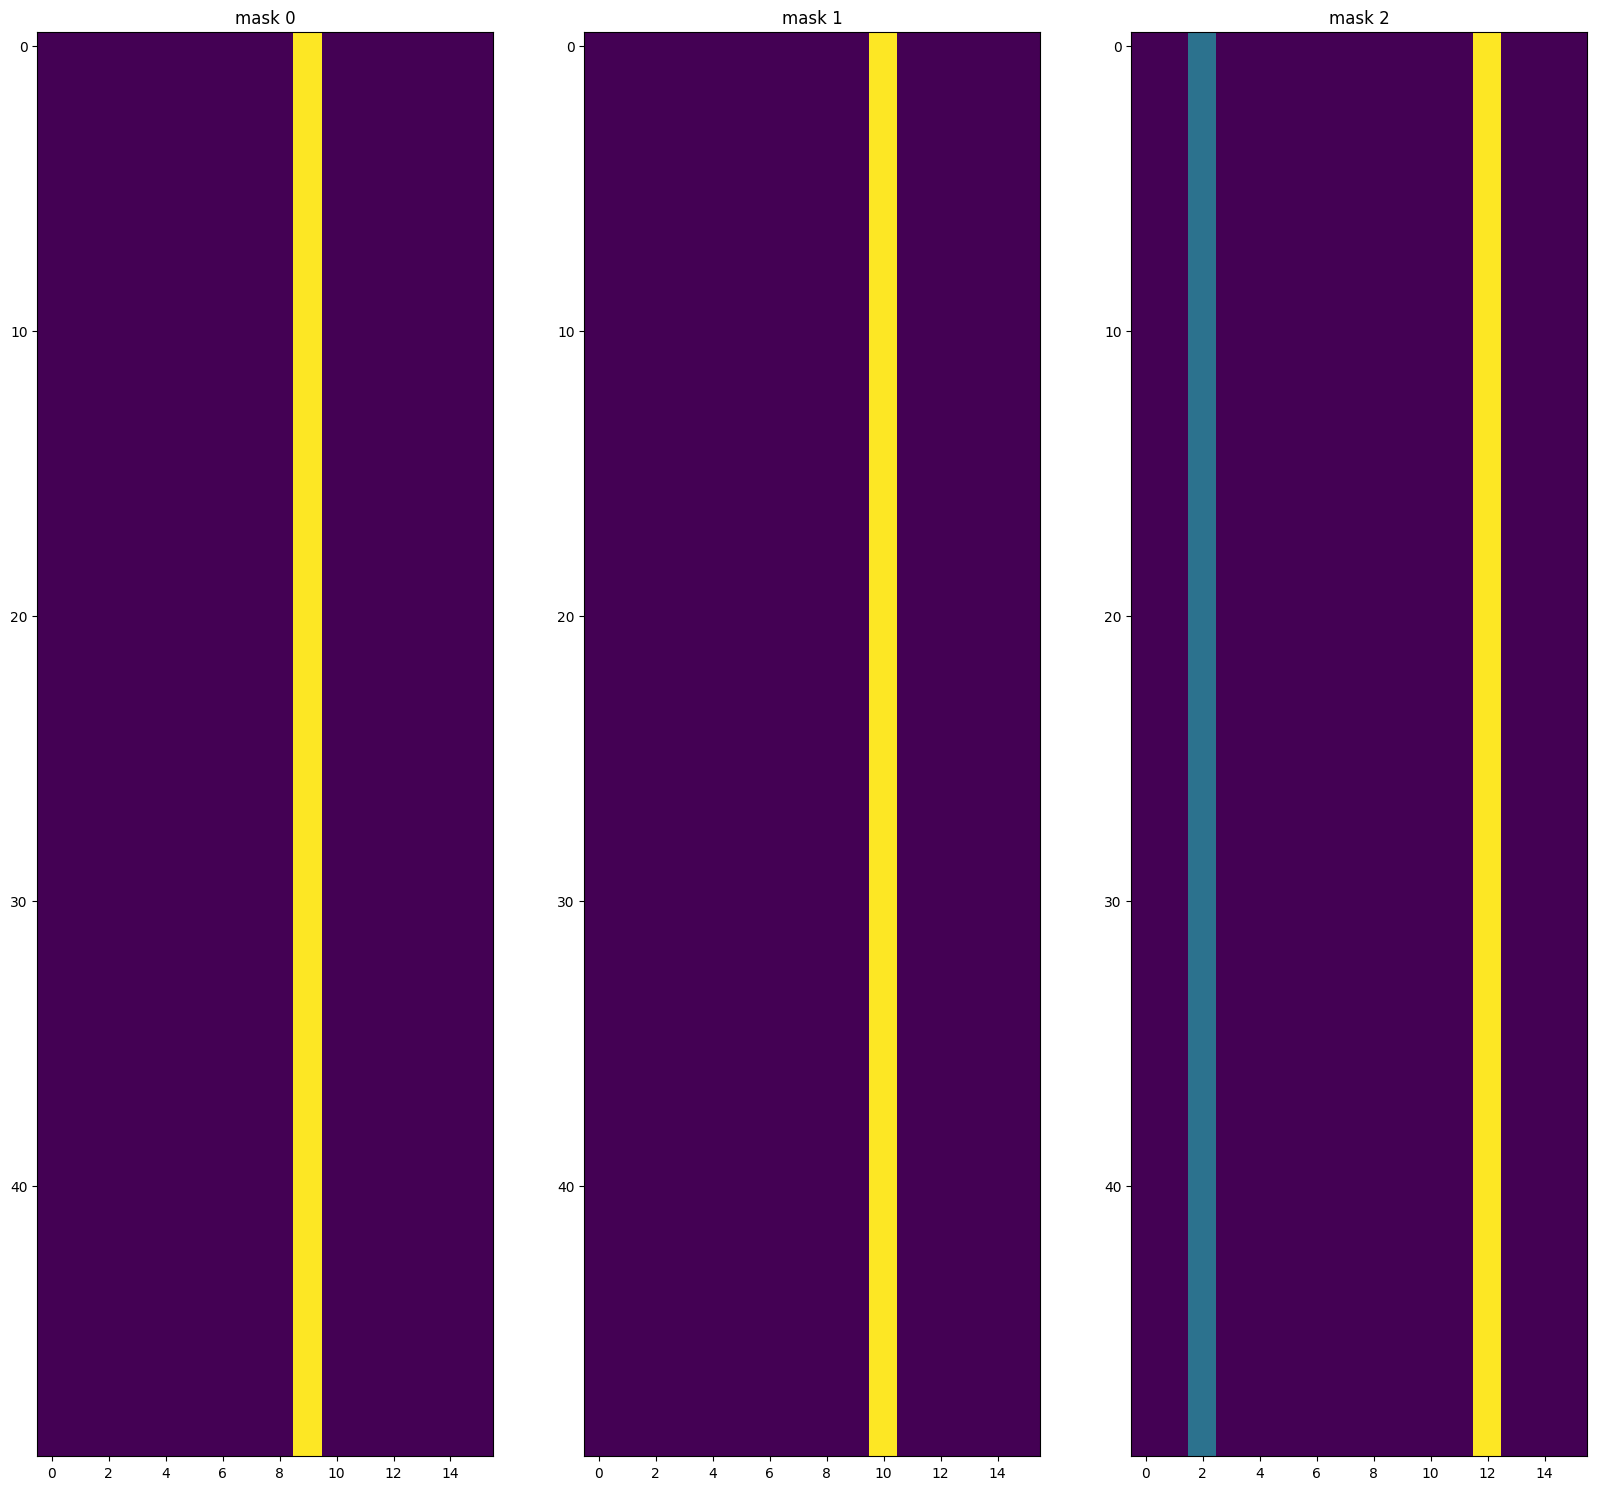

In [ ]:
explain_matrix_plot(model_g, X_g_test)

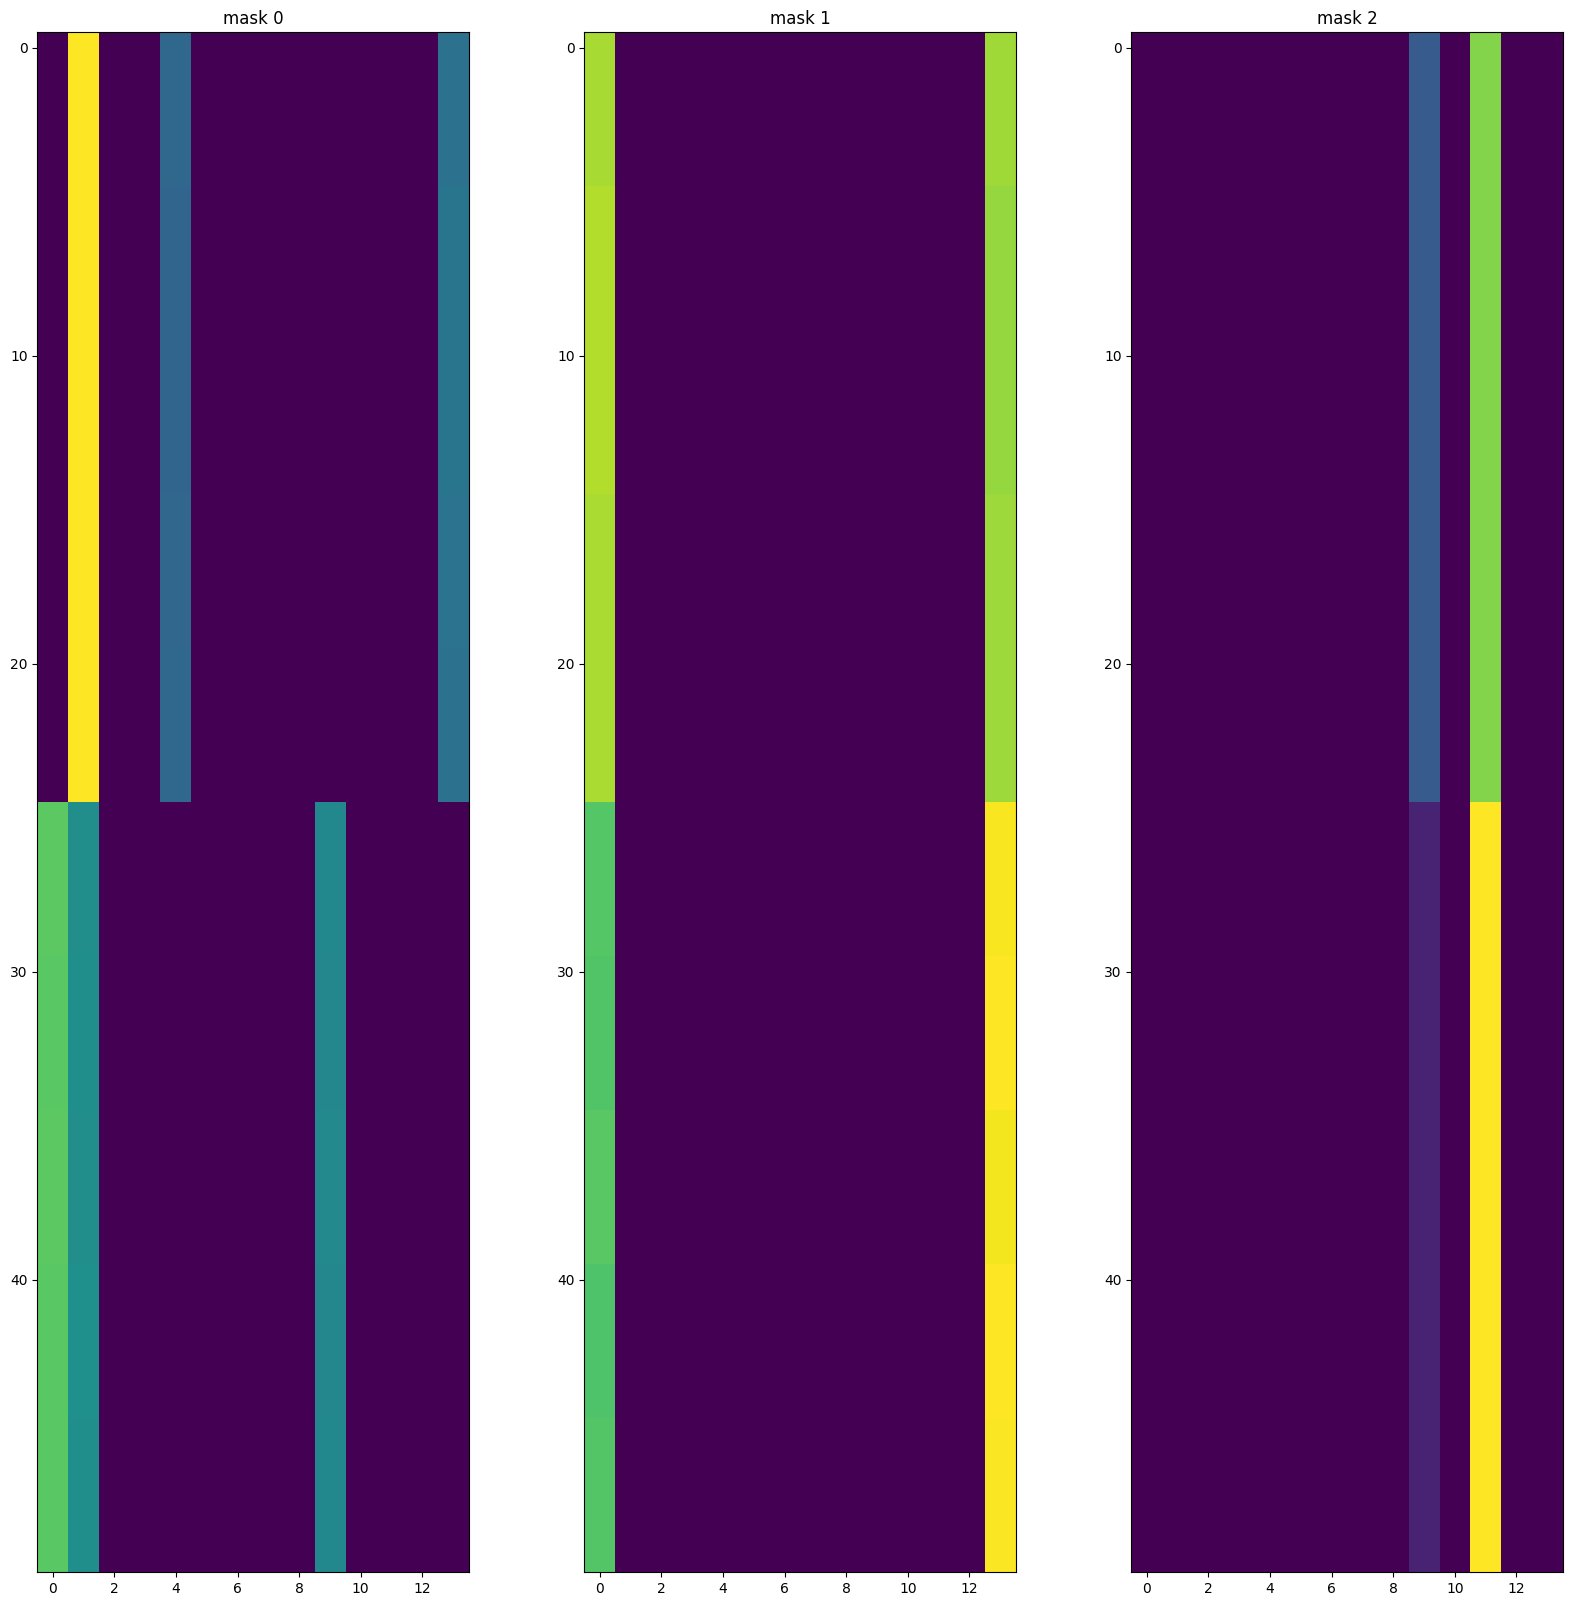

In [ ]:
explain_matrix_plot(model_st, X_st_test)

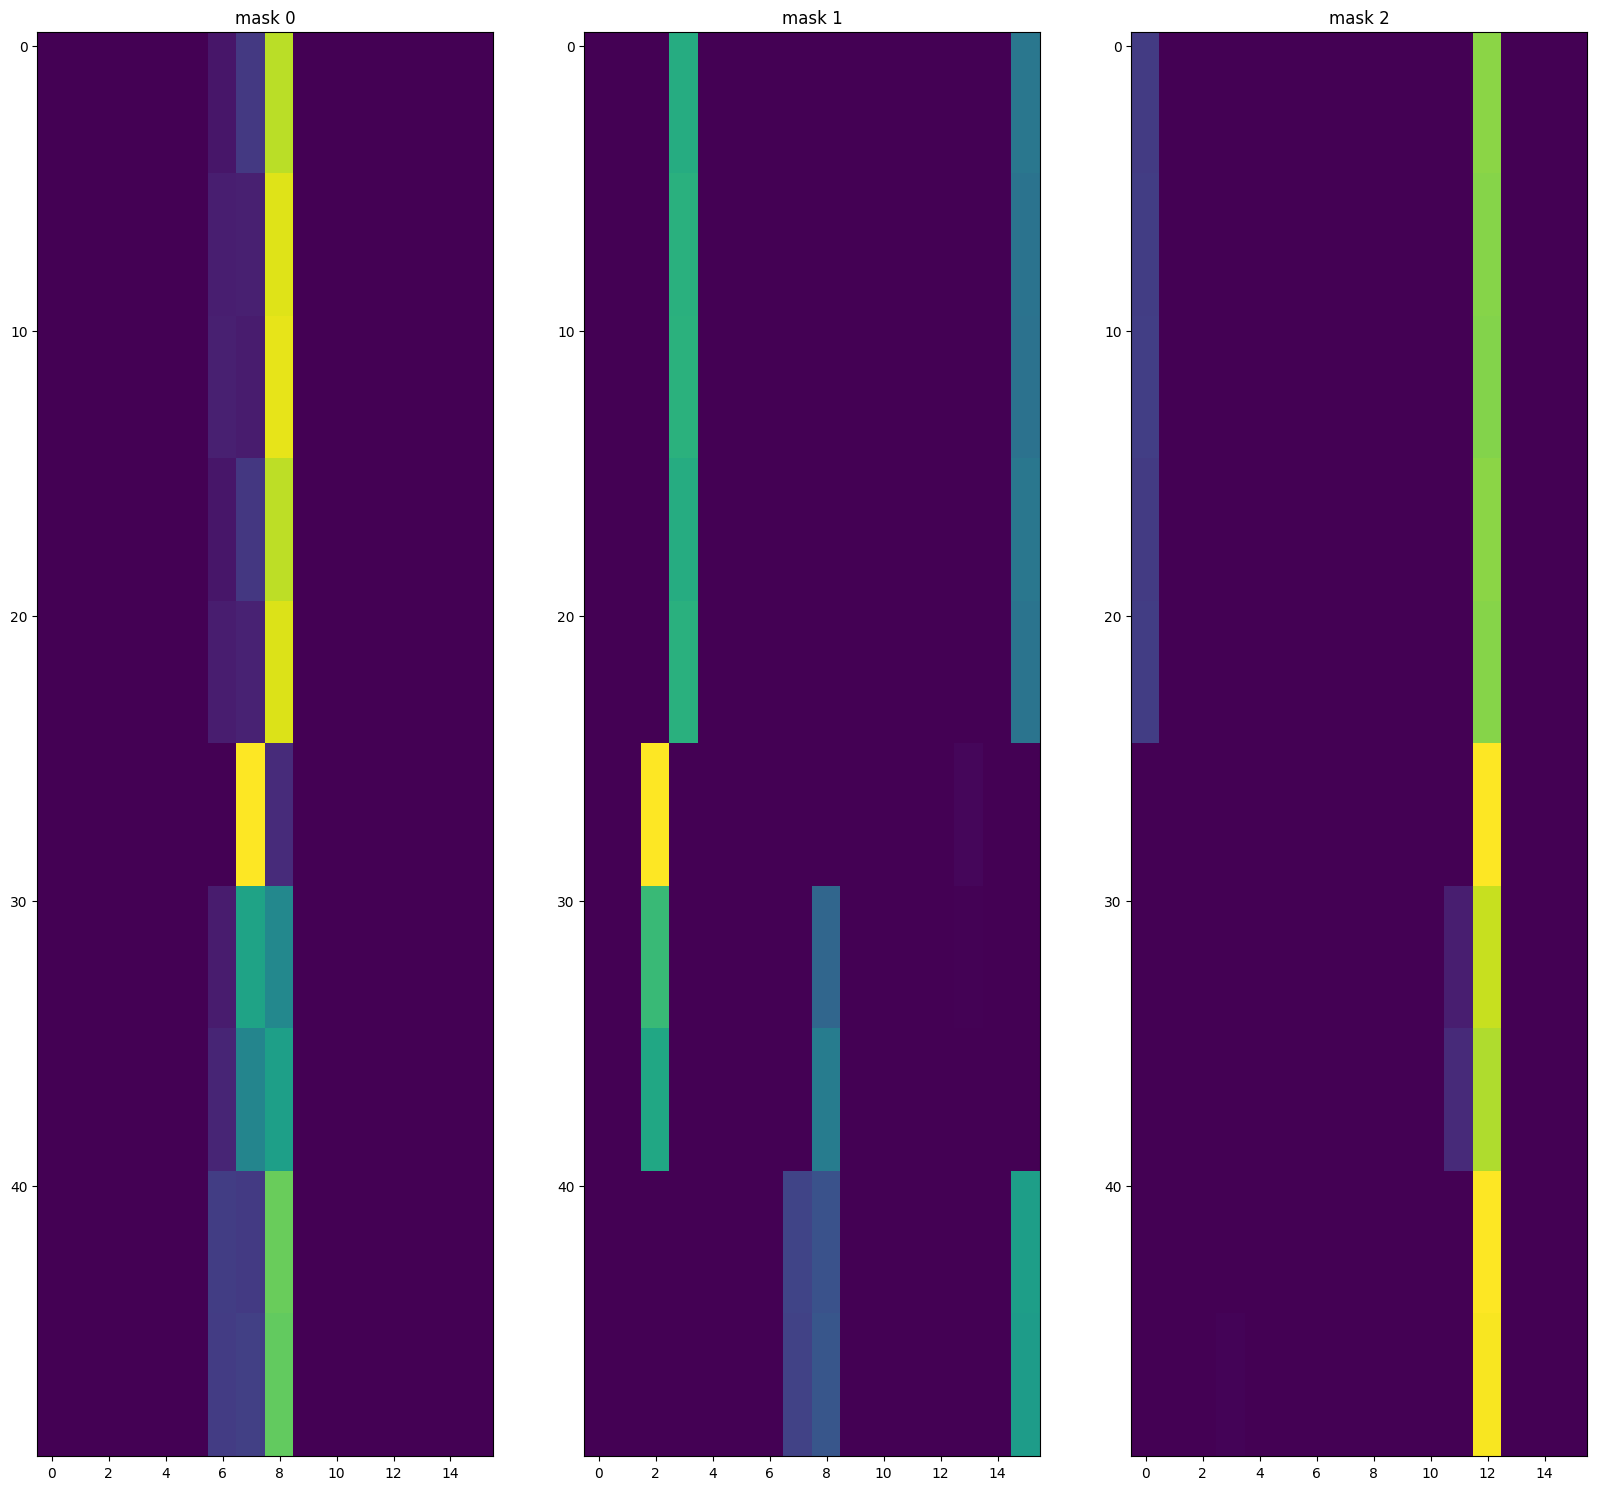

In [ ]:
explain_matrix_plot(model_mm, X_mm_test)